Statistics (I)(2) Final Project
===

<font face="微軟正黑體">
<b>組長</b> : 劉鎮霆 B07705015 <br>
<b>組員</b> : 黃煒勛 B07705010 | 黃　心 B07705013 | 康　崴 B07705014 | 張宇承 B07705017 | 李旻叡 B07705037
</font>

<font face="微軟正黑體">
讀取函式庫
</font>

In [27]:
import os
import sys
import random

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import numpy as np
import pandas as pd
pd.options.display.max_rows = 999

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as smm
import statsmodels
import statsmodels.stats.outliers_influence as sso

## <center>Table of Contents</center>

---

[<center><font face="微軟正黑體">分析主題</font></center>](#分析主題)
[<center><font face="微軟正黑體">動機</font></center>](#動機)
[<center><font face="微軟正黑體">敘述統計 & 視覺化</font></center>](#分析主題)
[<center><font face="微軟正黑體">假設檢定</font></center>](#動機)
[<center><font face="微軟正黑體">迴歸分析</font></center>](#分析主題)
[<center><font face="微軟正黑體">結論與建議</font></center>](#動機)

---


**<font face="微軟正黑體">分析主題</font>**
---

<font face="微軟正黑體">Spotify 串流平台中歌曲特性對熱門程度的影響</font>

**<font face="微軟正黑體">動機</font>**
---

<font face="微軟正黑體">
&emsp;&emsp;現今社會串流音樂蔚為主流，全世界有數億人在使用這類的服務。而在眾多的串流服務中又以 Spotify 為箇中翹楚，它有著 2.86 億個使用者，想必各個音樂發行商的競爭也是十分激烈。我們這些平時熱愛音樂的學生不禁好奇，一首歌要有怎麼樣的特性才可以在 Spotify 的使用環境中脫穎而出，得到較高的熱門程度。若是知道熱門程度與歌曲各項特性的關係，或許發行商可以根據此關係調整策略，獲得較高的觸及率和收益。
</font>

**<font face="微軟正黑體">資料集</font>**
---

### 1. **<font face="微軟正黑體">資料蒐集</font>**

<font face="微軟正黑體">
    &emsp;&emsp;我們首先在 kaggle 上找到
    <a href='https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db'>Spotify 歌曲資料集</a>,
    其中包含了每一首歌的歌曲類型、歌手、流行度 (popularity)、原聲性 (acousticness) 等數據。
    由於 kaggle 上的資料比較舊 (2019 年 3 月)，再加上其中的歌曲類型有經過人為處理 (例如將 kids 與 children 合併為一種類型)，因此我們決定參考它蒐集資料的方法，重新蒐集歌曲資料。<br>
    &emsp;&emsp;抽樣時，我們採用 stratified sampling，透過 Soptipy 函式庫搜尋 Spotify 上各個類型的歌曲 (會回傳歌曲資料的 list)，再各自隨機抽樣出 100 首歌，程式碼如下：<br>
    (由於不同時間的搜尋結果會不一樣，因此即使設定相同的 random seeds 也無法 reproduce，因此底下只是展示 api 的程式碼)
</font>

<font face="微軟正黑體">
    取得授權 (考量安全性問題，我們將用戶資料以 dictionary 的形式存在 <b>auth.npy</b>，資料的取得方式見此
    <a href='https://developer.spotify.com/documentation/general/guides/app-settings/'>連結</a>)
</font>

In [2]:
auth = np.load('auth.npy', allow_pickle=True)
os.environ["SPOTIPY_CLIENT_ID"] = auth.item().get('id')
os.environ["SPOTIPY_CLIENT_SECRET"] = auth.item().get('secret')
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(requests_timeout=None))

<font face="微軟正黑體">
    定義搜尋歌曲的函數
</font>

In [4]:
def search_genre(genre, offset=0, max_n=None):
    if max_n is None:
        max_n = sp.search(q=f'genre:"{genre}"', offset=0, limit=1, type='track').get('tracks').get('total')
    if max_n <= 50:
        search = sp.search(q=f'genre:"{genre}"', offset=offset, limit=max_n, type='track').get('tracks')
    else:
        search = {}
        search['total'] = 0
        search['items'] = []
        while search['total'] < max_n:
            step = search['total']+1
            print(f'\r[{step}/{max_n}] (search)', end='')
            num = min(50, max_n-search['total'])
            try:
                tmp = sp.search(q=f'genre:"{genre}"', offset=offset+search['total'], limit=num, type='track').get('tracks')
            except:
                break
            search['items'].extend(tmp.get('items'))
            search['total'] += len(tmp.get('items'))
    return search

def crawl(genres):
    variables = ['id', 
                 'name', 
                 'genre', 
                 'url', 
                 'popularity', 
                 'acousticness', 
                 'danceability',
                 'energy',
                 'instrumentalness',
                 'liveness',
                 'speechiness',
                 'duration_ms',
                 'key',
                 'loudness',
                 'mode',
                 'tempo',
                 'valence',
                 'available_market',
                 'release_date',
                 'explicit']
    columns = {v:[] for v in variables}
    data = pd.DataFrame(data=columns)
    for i, genre in enumerate(genres):
        n = sp.search(q=f'genre:"{genre}"', offset=0, limit=1, type='track').get('tracks').get('total')
        if n == 0:
            continue
        offsets = random.sample(list(np.arange(min(n-1, 1999))), k=min(n, 100))
        for j, offset in enumerate(offsets):
            print(f'\r[{j+1}/{len(offsets)}] (process)', end='')
            items = search_genre(genre, offset=offset, max_n=1).get('items')
            if items is None:
                continue
            result = items[0]
            feature = sp.audio_features(result.get('id'))[0]
            row = {
                'id': result.get('id') or '', 
                'name': result.get('name') or '', 
                'genre': genre, 
                'url': result.get('external_urls').get('spotify') or result.get('external_urls').get(list(result.get('external_urls').keys())[0]) or '',
                'popularity': result.get('popularity'),
                'available_market': len(result.get('available_markets')),
                'duration_ms': result.get('duration_ms'),
                'explicit': result.get('explicit'), # has explicit lyrics
                'release_date': result.get('album').get('release_date'),
                'acousticness': feature.get('acousticness'), 
                'danceability': feature.get('danceability'),
                'energy': feature.get('energy'),
                'instrumentalness': feature.get('instrumentalness'),
                'liveness': feature.get('liveness'),
                'speechiness': feature.get('speechiness'),
                'key': feature.get('key'),
                'loudness': feature.get('loudness'),
                'mode': feature.get('mode'),
                'tempo': feature.get('tempo'),
                'valence': feature.get('valence')
            }
            
            data = data.append(row, ignore_index=True)
        print(f'\r[{i+1}/{len(genres)}] genre: {genre}'.rjust(20, ' '))
    return data

<font face="微軟正黑體">
    開始搜尋，每項歌曲類型取 100 首歌
</font>

In [5]:
random.seed(113)
np.random.seed(113)
allGenres = sp.recommendation_genre_seeds()['genres']
data = crawl(allGenres)

[1/126] genre: acoustic
[2/126] genre: afrobeat
[3/126] genre: alt-rock
[4/126] genre: alternative
[5/126] genre: ambient
[6/126] genre: anime
[7/126] genre: black-metal
[8/126] genre: bluegrass
[9/126] genre: blues
[11/126] genre: brazil
[12/126] genre: breakbeat
[13/126] genre: british
[14/126] genre: cantopop
[15/126] genre: chicago-house
[16/126] genre: children
[17/126] genre: chill
[18/126] genre: classical
[19/126] genre: club
[20/126] genre: comedy
[21/126] genre: country
[22/126] genre: dance
[23/126] genre: dancehall
[24/126] genre: death-metal
[25/126] genre: deep-house
[26/126] genre: detroit-techno
[27/126] genre: disco
[28/126] genre: disney
[29/126] genre: drum-and-bass
[30/126] genre: dub
[31/126] genre: dubstep
[32/126] genre: edm
[33/126] genre: electro
[34/126] genre: electronic
[35/126] genre: emo
[36/126] genre: folk
[37/126] genre: forro
[38/126] genre: french
[39/126] genre: funk
[40/126] genre: garage
[41/126] genre: german
[42/126] genre: gospel
[43/126] genre:

<font face="微軟正黑體">
    檢查搜尋結果
</font>

In [20]:
data['idx'] = data.index
print('head:')
display(data.head())
print(f'genre counts: {len(data["genre"].unique())}')
print('genre:')
print(data['genre'].unique())

head:


,id,name,genre,url,popularity,acousticness,danceability,energy,instrumentalness,liveness,...,duration_ms,key,loudness,mode,tempo,valence,available_market,release_date,explicit,idx
0,3d3LHam2Lc5ADEyJxG3fXE,Thinking 'Bout Love,acoustic,https://open.spotify.com/track/3d3LHam2Lc5ADEy...,61.0,0.4870,0.732,0.328,0.000000,0.0677,...,199391.0,5.0,-8.130,1.0,141.789,0.385,79.0,2020-05-01,0.0,0
1,62h7AycdIWjq6uYWC0LBht,River,acoustic,https://open.spotify.com/track/62h7AycdIWjq6uY...,40.0,0.6150,0.322,0.265,0.000313,0.1000,...,323591.0,6.0,-12.899,1.0,176.398,0.236,77.0,2019-03-08,0.0,1
2,40zCruc5lh9gHw8QgZcNLi,Falling Faster,acoustic,https://open.spotify.com/track/40zCruc5lh9gHw8...,36.0,0.0726,0.580,0.832,0.002790,0.0902,...,266173.0,5.0,-6.180,1.0,121.994,0.676,79.0,2015-10-16,0.0,2
3,6gvlSiOrZQ4tIWquhRTC2W,Don't Cry For Me,acoustic,https://open.spotify.com/track/6gvlSiOrZQ4tIWq...,35.0,0.1130,0.703,0.651,0.000002,0.2220,...,182826.0,0.0,-5.758,0.0,149.943,0.338,79.0,2018-05-04,0.0,3
4,0mD8Oey9zR0TR8XyiOx3NO,Nothing More (feat. Lily Costner),acoustic,https://open.spotify.com/track/0mD8Oey9zR0TR8X...,37.0,0.0589,0.498,0.599,0.000000,0.1170,...,200960.0,0.0,-4.723,1.0,88.068,0.222,79.0,2013-09-30,0.0,4


genre counts: 112
genre:
['acoustic' 'afrobeat' 'alt-rock' 'alternative' 'ambient' 'anime'
 'black-metal' 'bluegrass' 'blues' 'brazil' 'breakbeat' 'british'
 'cantopop' 'chicago-house' 'children' 'chill' 'classical' 'club' 'comedy'
 'country' 'dance' 'dancehall' 'death-metal' 'deep-house' 'detroit-techno'
 'disco' 'disney' 'drum-and-bass' 'dub' 'dubstep' 'edm' 'electro'
 'electronic' 'emo' 'folk' 'forro' 'french' 'funk' 'garage' 'german'
 'gospel' 'goth' 'grindcore' 'groove' 'grunge' 'guitar' 'happy'
 'hard-rock' 'hardcore' 'hardstyle' 'heavy-metal' 'hip-hop' 'honky-tonk'
 'house' 'idm' 'indian' 'indie' 'indie-pop' 'industrial' 'iranian'
 'j-dance' 'j-idol' 'j-pop' 'j-rock' 'jazz' 'k-pop' 'kids' 'latin'
 'latino' 'malay' 'mandopop' 'metal' 'metalcore' 'minimal-techno' 'mpb'
 'new-age' 'opera' 'pagode' 'party' 'piano' 'pop' 'pop-film' 'power-pop'
 'progressive-house' 'psych-rock' 'punk' 'punk-rock' 'r-n-b' 'reggae'
 'reggaeton' 'rock' 'rock-n-roll' 'rockabilly' 'romance' 'salsa' 'samba'

<font face="微軟正黑體">
    我們可以看出 126 項歌曲類型中，有 112 項爬取成功，接著檢查每項歌曲種類成功爬取的歌曲數
</font>

In [21]:
data['genre'].value_counts()

electro              100
alternative          100
alt-rock             100
heavy-metal          100
turkish              100
ambient              100
sertanejo            100
disco                100
comedy               100
mandopop             100
british              100
rock-n-roll          100
k-pop                100
idm                  100
pagode               100
j-idol               100
opera                100
new-age              100
guitar               100
rockabilly           100
sleep                100
r-n-b                100
minimal-techno       100
ska                  100
goth                 100
reggaeton            100
acoustic             100
indie-pop            100
dubstep              100
blues                100
mpb                  100
swedish              100
edm                  100
metalcore            100
kids                 100
emo                  100
reggae               100
show-tunes           100
j-rock               100
pop-film             100


<font face="微軟正黑體">
    112 項歌曲種類皆爬取 100 首歌，我們先將資料存取起來
</font>

In [22]:
data.to_csv('example.csv', encoding="utf-8", index=False)

<font face="微軟正黑體">
    由於有些歌可能同時被歸類在多種歌曲類型，因此我們需要刪除重複的項目，在這裡我們使用 <b>random.randint</b> 函數隨機選取要留下的歌曲
</font>

In [49]:
data = pd.read_csv('example.csv', encoding="utf-8", index_col=False)
duplicates = data['id'].value_counts()[data['id'].value_counts() > 1].index
tmp = data.loc[[n in duplicates for n in data['id']]]
tmp = tmp.sort_values(by=['id', 'idx'])

random.seed(113)
n = len(tmp['id'].unique())
for i, ID in enumerate(tmp['id'].unique()):
    print(f'[{i+1}/{n}]', end='\r')
    remove = tmp[tmp['id'] == ID]['idx'].values
    leave = random.randint(0, len(tmp[tmp['id'] == ID])-1)
    remove = np.delete(remove, leave)
    data = data[[i not in remove for i in data['idx']]]
print('Head of data:')
display(data.head())

Head of data:


,id,name,genre,url,popularity,acousticness,danceability,energy,instrumentalness,liveness,...,duration_ms,key,loudness,mode,tempo,valence,available_market,release_date,explicit,idx
0,3d3LHam2Lc5ADEyJxG3fXE,Thinking 'Bout Love,acoustic,https://open.spotify.com/track/3d3LHam2Lc5ADEy...,61.0,0.4870,0.732,0.328,0.000000,0.0677,...,199391.0,5.0,-8.130,1.0,141.789,0.385,79.0,2020-05-01,0.0,0
1,62h7AycdIWjq6uYWC0LBht,River,acoustic,https://open.spotify.com/track/62h7AycdIWjq6uY...,40.0,0.6150,0.322,0.265,0.000313,0.1000,...,323591.0,6.0,-12.899,1.0,176.398,0.236,77.0,2019-03-08,0.0,1
2,40zCruc5lh9gHw8QgZcNLi,Falling Faster,acoustic,https://open.spotify.com/track/40zCruc5lh9gHw8...,36.0,0.0726,0.580,0.832,0.002790,0.0902,...,266173.0,5.0,-6.180,1.0,121.994,0.676,79.0,2015-10-16,0.0,2
3,6gvlSiOrZQ4tIWquhRTC2W,Don't Cry For Me,acoustic,https://open.spotify.com/track/6gvlSiOrZQ4tIWq...,35.0,0.1130,0.703,0.651,0.000002,0.2220,...,182826.0,0.0,-5.758,0.0,149.943,0.338,79.0,2018-05-04,0.0,3
4,0mD8Oey9zR0TR8XyiOx3NO,Nothing More (feat. Lily Costner),acoustic,https://open.spotify.com/track/0mD8Oey9zR0TR8X...,37.0,0.0589,0.498,0.599,0.000000,0.1170,...,200960.0,0.0,-4.723,1.0,88.068,0.222,79.0,2013-09-30,0.0,4


In [24]:
data.to_csv('example_no_duplicate.csv', encoding="utf-8", index=False)

<font face="微軟正黑體">
    接著，我們發現 2020 年 5 月份以後的熱門度普遍偏低，且分布呈現 right-skewed，有可能是因為 Spotify 使用歌曲的總播放數與近期播放數衡量它的熱門程度，導致新出的歌曲熱門度不高，如下：
</font>

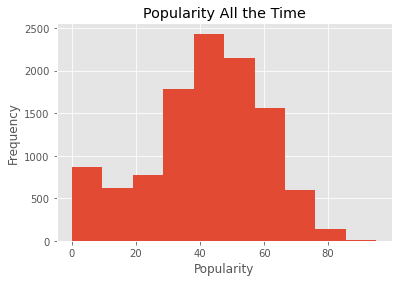

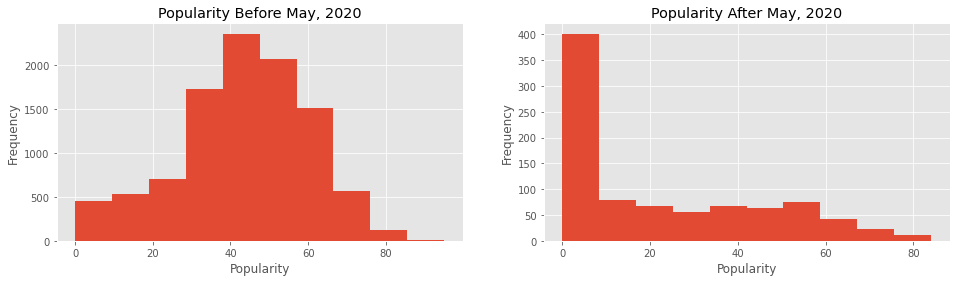

In [46]:
data = pd.read_csv('example_no_duplicate.csv', encoding="utf-8", index_col=False)
data['popularity'].hist()
plt.title('Popularity All the Time')
plt.xlabel('Popularity')
plt.ylabel('Frequency')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(16, 4))
data.loc[np.array([d < '2020-05' for d in data['release_date']]), 'popularity'].hist(ax=axs[0])
axs[0].set_title('Popularity Before May, 2020')
axs[0].set_xlabel('Popularity')
axs[0].set_ylabel('Frequency')
data.loc[np.array([d >= '2020-05' for d in data['release_date']]), 'popularity'].hist(ax=axs[1])
axs[1].set_title('Popularity After May, 2020')
axs[1].set_xlabel('Popularity')
axs[1].set_ylabel('Frequency')
plt.show()

<font face="微軟正黑體">
    基於以上因素，我們認為 2020 年 5 月以後歌曲的熱門程度可能沒辦法代表這首歌真實的熱門度，因此我們選擇將這些歌曲移除，並檢查移除後每個歌曲類型剩下的歌曲數
</font>

In [48]:
data = data.iloc[np.array(data['release_date'] < '2020-05'), :]
data['genre'].value_counts()

goth                 100
grindcore            100
show-tunes           100
kids                 100
gospel                99
trip-hop              99
j-rock                99
disney                99
comedy                98
iranian               98
heavy-metal           98
j-idol                98
mandopop              97
breakbeat             97
club                  97
ambient               97
detroit-techno        97
new-age               97
sleep                 97
romance               97
honky-tonk            97
bluegrass             97
cantopop              97
rockabilly            97
hardcore              96
idm                   96
industrial            96
ska                   96
afrobeat              96
dub                   96
malay                 96
children              96
piano                 95
chicago-house         95
tango                 95
j-dance               95
singer-songwriter     95
anime                 95
dubstep               94
drum-and-bass         94


<font face="微軟正黑體">
    可以發現大多數歌曲都還有 70 首以上的歌，但是 german 與 classical 的歌只剩下 26 首與 3 首
</font>

<font face="微軟正黑體">
    將資料存取起來
</font>

In [50]:
data.to_csv('example_no_may.csv', encoding="utf-8", index=False)

**<font face="微軟正黑體">敘述統計 & 視覺化</font>**
---

In [58]:
df = pd.read_csv("tracks.csv")

### 1. **<font face="微軟正黑體">欄位介紹</font>**

- name: 歌曲名稱<br>
- available_market: 歌曲在多少地區可以被取得<br>
- explicit: 是否有明確的歌詞 (由提供者標示)<br>
- genre: 歌曲種類，共 112 種 (每種各 100 首歌)<br>
- popularity: 流行程度，數值範圍為 0到100。評分標準主要基於播放總數及近期播放數。一般來說，最近常播放的歌曲比過去常播放的歌曲有更高的流行度。<br>
- acousticness: 原聲性，數值範圍為 0到1。1 代表有很高的信心認定這首歌是不經過電子音效處理，可以聽到最直接的樂音及人聲。<br>
- danceability: 舞蹈性，數值範圍為 0到1。根據拍子、節奏和整體規律來決定是否適合跳舞。<br>
- duration_ms: 歌曲長度，以毫秒為單位。<br>
- energy: 能量，數值範圍為 0到1。代表感受上的強度與活力。一般來說，從有能量的歌曲會感受到快、大聲與嘈雜，而評分的特徵包含dynamic range、 perceived loudness, timbre, onset rate, 和general entropy。<br>
- instrumentalness: 樂器性，數值範圍為 0到1。偵測歌曲是否沒有人聲 (哼唱算樂器，而說唱或言語則為人聲)，此數值 >0.5 即可代表純樂器，不過越接近 1 信心水準越高。<br>
- key: 調，代表不同 standard Pitch Class notation，如 0=C, 1=C♯/D♭, 2=D，若無則為-1。<br>
- liveness: 數值範圍為 0到1。越高代表現場演奏的可能性高，>0.8表示極有可能為現場演奏。<br>
- loudness: 歌曲整體的響度，單位為分貝 (dB)，數值為整首歌的平均值，大部分在 -60至0。<br>
- mode: 調式，大調為1，小調為0。<br>
- speechiness: 言語性，數值範圍為 0到1。越接近純粹的言語 (如:脫口秀、有聲書、誦詩)，此數值越接近 1，>0.66 代表很有可能皆為言語所構成，0.33到0.66 則可能有部分為言語(如:說唱)，<0.33 為音樂或其他非言語性歌曲。<br>
- tempo: 節奏，單位為 beats per minute (BPM)。<br>
- valence: 正向性，數值範圍為 0到1，較高代表此音樂聽起來較為正面，較低則為負面。

### 2. **<font face="微軟正黑體">歌曲類型選擇與熱門度觀察</font>**

In [21]:
cato = [ 'j-pop', 'k-pop', 'rock', 'metal', 'hip-hop', 'opera', 'country', 'dance', 'jazz', 'pop', 'blues', 'j-idol', 'disney']

我們選擇了'j-pop', 'k-pop', 'rock', 'metal', 'hip-hop', 'opera', 'country', 'dance', 'jazz', 'pop', 'blues',  'j-idol', 'disney'共13種歌曲類型

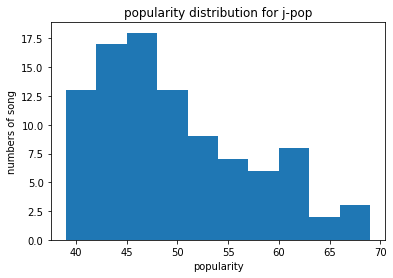

mean of popularity  49.291666666666664
min of popularity  39.0
max of popularity  69.0
standard deviation of popularity  7.346917243474037
skewness of popularity  0.6929780661163695
kurtosis of popularity  -0.4024851529691178


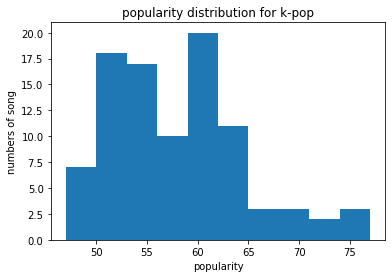

mean of popularity  57.54255319148936
min of popularity  47.0
max of popularity  77.0
standard deviation of popularity  6.559348403281751
skewness of popularity  0.7978654828632658
kurtosis of popularity  0.423048458697024


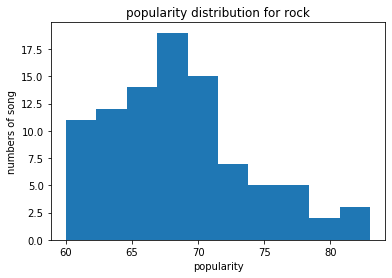

mean of popularity  68.47311827956989
min of popularity  60.0
max of popularity  83.0
standard deviation of popularity  5.339743109456512
skewness of popularity  0.756332009344692
kurtosis of popularity  0.1210006505595227


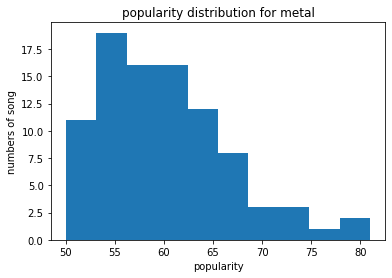

mean of popularity  60.07692307692308
min of popularity  50.0
max of popularity  81.0
standard deviation of popularity  6.384409429280343
skewness of popularity  0.8519002270976225
kurtosis of popularity  0.6004357095681678


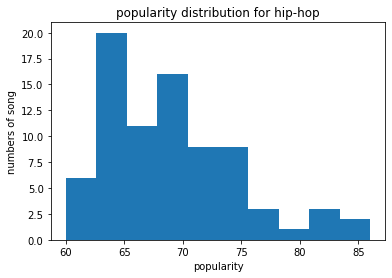

mean of popularity  68.9125
min of popularity  60.0
max of popularity  86.0
standard deviation of popularity  5.774658190333854
skewness of popularity  0.8799568929287541
kurtosis of popularity  0.45772898318637845


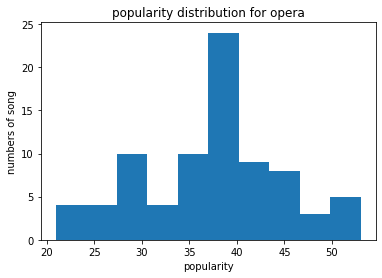

mean of popularity  37.25925925925926
min of popularity  21.0
max of popularity  53.0
standard deviation of popularity  7.461195912482425
skewness of popularity  -0.09303452227746001
kurtosis of popularity  -0.33878830792962455


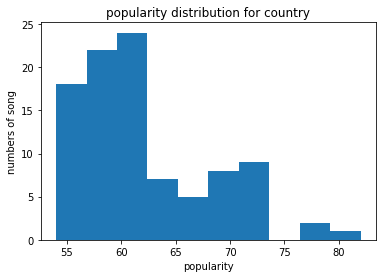

mean of popularity  61.989583333333336
min of popularity  54.0
max of popularity  82.0
standard deviation of popularity  6.072361530854658
skewness of popularity  0.9170206175208505
kurtosis of popularity  0.34562439793597965


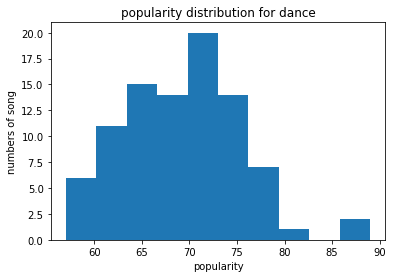

mean of popularity  69.23333333333333
min of popularity  57.0
max of popularity  89.0
standard deviation of popularity  6.14625125538991
skewness of popularity  0.5013524717490567
kurtosis of popularity  0.6098109940109495


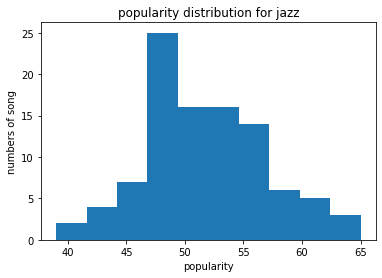

mean of popularity  51.45918367346939
min of popularity  39.0
max of popularity  65.0
standard deviation of popularity  5.133613440414755
skewness of popularity  0.25965050179938787
kurtosis of popularity  0.0816017783148899


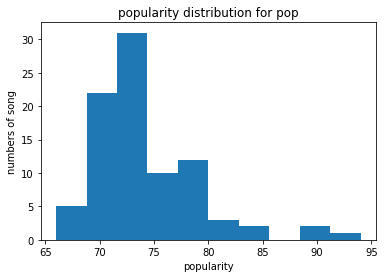

mean of popularity  74.19318181818181
min of popularity  66.0
max of popularity  94.0
standard deviation of popularity  5.014594686972034
skewness of popularity  1.3484128528030743
kurtosis of popularity  2.8739840419693037


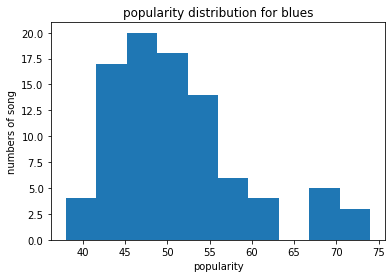

mean of popularity  51.34065934065934
min of popularity  38.0
max of popularity  74.0
standard deviation of popularity  7.820514021497537
skewness of popularity  1.0877268284029413
kurtosis of popularity  0.9821078346370067


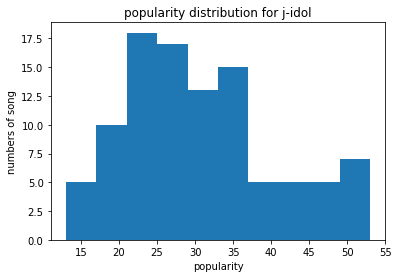

mean of popularity  30.47
min of popularity  13.0
max of popularity  53.0
standard deviation of popularity  9.82622239035157
skewness of popularity  0.5664259121595978
kurtosis of popularity  -0.42453877024001985


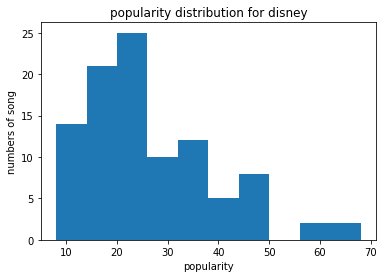

mean of popularity  26.07070707070707
min of popularity  8.0
max of popularity  68.0
standard deviation of popularity  12.784120032491622
skewness of popularity  1.048023482053721
kurtosis of popularity  0.7835789220041547


In [22]:
data_collect = pd.DataFrame(columns=df.columns) 

for i in range(0,len(cato)):
    data_cato = df[df['genre'] == cato[i]]
    #display(data_cato.head())
        
    #作圖，繪出popularity散佈圖
    plt.hist(data_cato['popularity'],bins = 10) 
    plt.xlabel("popularity")
    plt.ylabel("numbers of song")
    title = "popularity distribution for "+cato[i]
    plt.title(title)
    plt.show()
    
    mean = data_cato['popularity'].mean()
    minimum = min(data_cato['popularity'])
    maximum = max(data_cato['popularity'])
    kurtosis = stats.kurtosis(data_cato['popularity'].values)
    skewness = stats.skew(data_cato['popularity'].values)
    std = data_cato['popularity'].std()
    

    print("mean of popularity ",mean)
    print("min of popularity ",minimum)
    print("max of popularity ",maximum)
    print("standard deviation of popularity ",std)
    print("skewness of popularity ",skewness)
    print("kurtosis of popularity ",kurtosis)
    
    data_collect = pd.concat([data_collect,data_cato])
    
# 看每種歌曲的popularity相關資料
summary = data_collect[['popularity','genre']].groupby('genre').describe()

In [32]:
summary

popularity                                                      
             count       mean        std   min    25%   50%    75%   max
genre                                                                   
blues         91.0  51.340659   7.820514  38.0  46.00  50.0  55.00  74.0
country       96.0  61.989583   6.072362  54.0  58.00  61.0  66.00  82.0
dance         90.0  69.233333   6.146251  57.0  65.00  69.0  73.00  89.0
disney        99.0  26.070707  12.784120   8.0  16.50  23.0  33.50  68.0
hip-hop       80.0  68.912500   5.774658  60.0  64.75  68.0  72.00  86.0
j-idol       100.0  30.470000   9.826222  13.0  23.75  28.5  35.25  53.0
j-pop         96.0  49.291667   7.346917  39.0  44.00  47.5  55.00  69.0
jazz          98.0  51.459184   5.133613  39.0  48.00  51.0  55.00  65.0
k-pop         94.0  57.542553   6.559348  47.0  52.00  57.0  61.00  77.0
metal         91.0  60.076923   6.384409  50.0  55.00  59.0  63.50  81.0
opera         81.0  37.259259   7.461196  21.0  33.00  38.0  41.00  53.0
pop           88.0  74.193182   5.014595  66.0  71.00  73.0  77.00  94.0
rock          93.0  68.473118   5.339743  60.0  65.00  67.0  71.00  83.0

### 2.1 觀察每個歌曲類型的熱門程度平均數

In [31]:
data_mean = summary.iloc[:,1] #取mean欄位
data_mean = data_mean.sort_values() #由小到大排序
print(data_mean)

genre
disney     26.070707
j-idol     30.470000
opera      37.259259
j-pop      49.291667
blues      51.340659
jazz       51.459184
k-pop      57.542553
metal      60.076923
country    61.989583
rock       68.473118
hip-hop    68.912500
dance      69.233333
pop        74.193182
Name: (popularity, mean), dtype: float64


我們發現pop的平均熱門程度最高，disney最低。這個結果顯示各分類的熱門程度的平均數有明顯的差異，而不同分類的歌曲在各項特性會有差異，這讓我們好奇不同的特性會對歌曲的熱門程度造成什麼影響

### 2.2 觀察每個歌曲類型的熱門程度標準差

In [20]:
data_std = summary.iloc[:,2] #取std欄位
data_std = data_std.sort_values() #由小到大排序
print(data_std)

genre
pop         5.014595
jazz        5.133613
rock        5.339743
hip-hop     5.774658
country     6.072362
dance       6.146251
metal       6.384409
k-pop       6.559348
j-pop       7.346917
opera       7.461196
blues       7.820514
j-idol      9.826222
disney     12.784120
Name: (popularity, std), dtype: float64


我們發現pop的標準差最低，disney最高，這邊有一個十分有趣的現象，先前mean較高的歌曲類型通常會有較低的標準差

### 2.3 skewness and kurtosis

我們發現大部分的歌曲類型的熱門程度分佈都具備right-skewed的性質，而在kurtosis方面，只有pop超過1和blues接近1，顯示他們的分佈較為集中

### 2.4 檢查Outliers

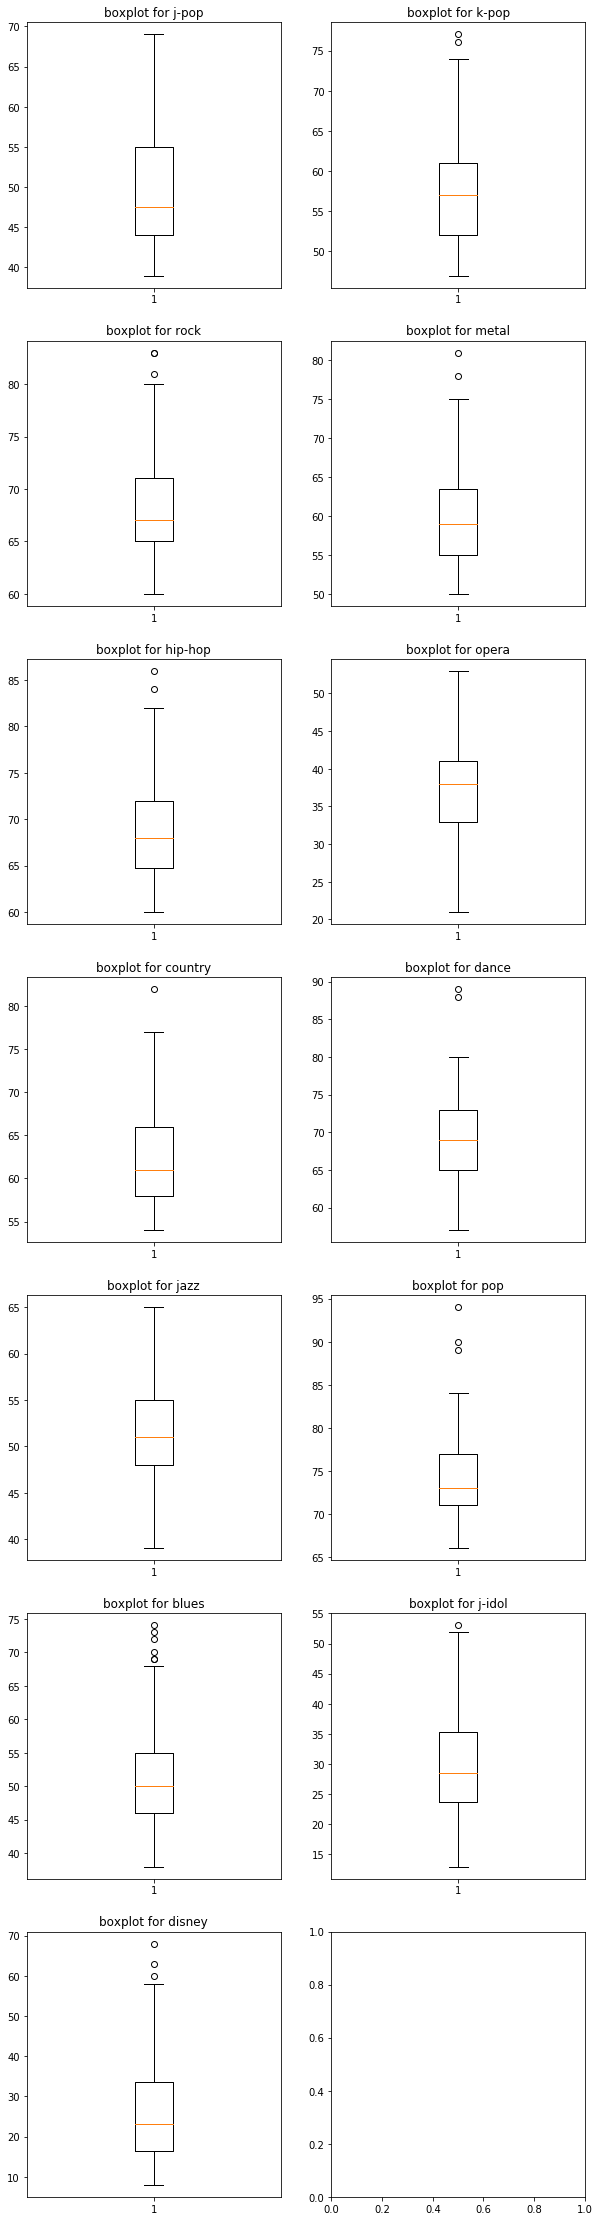

In [48]:
fig, axs = plt.subplots(int(len(cato)/2+1), 2, figsize=(10,40))

for i in range(0,len(cato)):
    data_cato = df[df['genre'] == cato[i]]
    #display(data_cato.head())
    
    #作圖，繪出popularity盒狀圖
    #data_cato['popularity'].plot(kind="box")
    axs[int(i/2), i%2].boxplot(data_cato['popularity'])
    title = "boxplot for "+cato[i]
    axs[int(i/2), i%2].set_title(title)

plt.show()

從各個歌曲分類的boxplot來看，outliers並不多

**<font face="微軟正黑體">假設檢定</font>**
---

**<font face="微軟正黑體">迴歸分析</font>**
---

**<font face="微軟正黑體">結論與建議</font>**
---